# Multi-Image Stitching with **Custom RANSAC Transforms** + **Multi-Band Blending**

**Includes:**
- DoG+Harris keypoint detector
- ORB descriptors and BF matching (ratio test)
- **Custom robust transform estimation** (no `cv2.findHomography`):
  - Homography (Normalized DLT + RANSAC)
  - Affine (linear LS + RANSAC)
  - Euclidean (rotation+translation; Kabsch + RANSAC)
- Warp all images to a common canvas and **multi-band blending** (Laplacian pyramids)

Outputs will be written into `./multi_custom_outputs/`.


In [1]:
# !pip install opencv-python numpy matplotlib
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

ROOT_DIR = 'D:/Teach_n_Train/Advanced_Lessons_CV/LABS/Image_Matching_harris/'

OUT_DIR = Path(ROOT_DIR + 'multi_custom_outputs') 
OUT_DIR.mkdir(parents=True, exist_ok=True)
print('Output dir:', OUT_DIR.resolve())

# -------- DoG + Harris detector --------
SIGMA0 = 1.6
SCALES_PER_OCT = 3
NUM_OCTAVES = 4
CONTRAST_TH = 0.03
EDGE_R = 10
HARRIS_K = 0.04
HARRIS_REL_TH = 0.01
NMS_RADIUS = 3
DRAW_SIZE = 3

def gaussian_blur(img, sigma):
    ksize = max(3, int(np.ceil(sigma*6))|1)
    return cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma, sigmaY=sigma, borderType=cv2.BORDER_REPLICATE)

def build_gaussian_pyramid(gray, num_octaves=NUM_OCTAVES, s=SCALES_PER_OCT, sigma0=SIGMA0):
    base = gray.astype(np.float32) / 255.0
    k = 2 ** (1.0 / s)
    gauss_pyr, sigmas_pyr = [], []
    for o in range(num_octaves):
        octave_imgs, octave_sigmas = [], []
        sigmas = [sigma0 * (k**i) for i in range(s + 3)]
        if o == 0:
            prev = gaussian_blur(base, np.sqrt(max(sigmas[0]**2 - 0.5**2, 1e-6)))
        else:
            prev = cv2.resize(gauss_pyr[o-1][s], (base.shape[1] >> o, base.shape[0] >> o), interpolation=cv2.INTER_NEAREST)
        octave_imgs.append(prev); octave_sigmas.append(sigmas[0])
        for i in range(1, s+3):
            sigma_prev, sigma_curr = sigmas[i-1], sigmas[i]
            sigma_inc = np.sqrt(max(sigma_curr**2 - sigma_prev**2, 1e-6))
            blur = gaussian_blur(octave_imgs[-1], sigma_inc)
            octave_imgs.append(blur); octave_sigmas.append(sigmas[i])
        gauss_pyr.append(octave_imgs); sigmas_pyr.append(octave_sigmas)
    return gauss_pyr, sigmas_pyr

def build_dog_pyramid(gauss_pyr):
    dog_pyr = []
    for octave_imgs in gauss_pyr:
        dogs = [octave_imgs[i] - octave_imgs[i-1] for i in range(1, len(octave_imgs))]
        dog_pyr.append(dogs)
    return dog_pyr

def is_local_extrema(cube):
    c = cube[1,1,1]
    if c > 0: return c == cube.max()
    else:     return c == cube.min()

def pass_edge_response(dog, y, x, r=EDGE_R):
    Dxx = dog[y, x+1] + dog[y, x-1] - 2*dog[y, x]
    Dyy = dog[y+1, x] + dog[y-1, x] - 2*dog[y, x]
    Dxy = (dog[y+1, x+1] - dog[y+1, x-1] - dog[y-1, x+1] + dog[y-1, x-1]) * 0.25
    Tr = Dxx + Dyy
    Det = Dxx*Dyy - Dxy*Dxy
    if Det <= 0: return False
    ratio = (Tr*Tr) / Det
    rcrit = ((r + 1.0)**2) / r
    return ratio < rcrit

def harris_response(img, k=HARRIS_K, win_sigma=1.0):
    Ix = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3, borderType=cv2.BORDER_REPLICATE)
    Iy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3, borderType=cv2.BORDER_REPLICATE)
    Ixx, Iyy, Ixy = Ix*Ix, Iy*Iy, Ix*Iy
    Sxx = gaussian_blur(Ixx, win_sigma)
    Syy = gaussian_blur(Iyy, win_sigma)
    Sxy = gaussian_blur(Ixy, win_sigma)
    detM = Sxx*Syy - Sxy*Sxy
    traceM = Sxx + Syy
    R = detM - k*(traceM**2)
    return R

def nonmax_suppression(points, radius):
    if not points: return []
    pts = np.array(points)
    order = np.argsort(-pts[:,2])
    kept, taken = [], np.zeros(len(points), dtype=bool)
    for i in order:
        if taken[i]: continue
        yi, xi, _ = pts[i]
        kept.append(points[i])
        dy = pts[:,0] - yi
        dx = pts[:,1] - xi
        mask = (dx*dx + dy*dy) <= (radius*radius)
        taken = taken | mask
    return kept

def detect_keypoints_dog_harris(gray,
                                num_octaves=NUM_OCTAVES,
                                s=SCALES_PER_OCT,
                                sigma0=SIGMA0,
                                contrast_th=CONTRAST_TH,
                                edge_r=EDGE_R,
                                harris_k=HARRIS_K,
                                harris_rel_th=HARRIS_REL_TH,
                                nms_radius=NMS_RADIUS):
    gauss_pyr, _ = build_gaussian_pyramid(gray, num_octaves, s, sigma0)
    dog_pyr = build_dog_pyramid(gauss_pyr)
    from collections import defaultdict
    buckets = defaultdict(list)
    for o in range(num_octaves):
        dogs = dog_pyr[o]
        gaussians = gauss_pyr[o]
        H, W = dogs[0].shape
        harris_list = []
        for gi in range(1, s+2):
            R = harris_response(gaussians[gi], k=harris_k, win_sigma=1.0)
            Rmax = float(np.max(R)) if R.size else 1.0
            thr = harris_rel_th * (Rmax if Rmax > 1e-12 else 1.0)
            harris_list.append((R, thr))
        for i in range(1, s+1):
            dog_prev, dog_curr, dog_next = dogs[i-1], dogs[i], dogs[i+1]
            R, R_thr = harris_list[i-1]
            for y in range(1, H-1):
                for x in range(1, W-1):
                    val = dog_curr[y, x]
                    if abs(val) < contrast_th: continue
                    cube = np.stack([
                        dog_prev[y-1:y+2, x-1:x+2],
                        dog_curr[y-1:y+2, x-1:x+2],
                        dog_next[y-1:y+2, x-1:x+2]
                    ], axis=0)
                    if not is_local_extrema(cube): continue
                    if not pass_edge_response(dog_curr, y, x, r=edge_r): continue
                    Rh = R[y, x]
                    if Rh <= R_thr: continue
                    buckets[(o, i)].append((y, x, float(Rh)))
    final_points = []
    for (o, i), pts in buckets.items():
        kept = nonmax_suppression(pts, radius=nms_radius)
        scale_factor = (2 ** o)
        for (y, x, sc) in kept:
            x0 = int(x * scale_factor)
            y0 = int(y * scale_factor)
            sigma = SIGMA0 * (2 ** (o + i / float(SCALES_PER_OCT)))
            final_points.append({'x':x0,'y':y0,'octave':o,'scale_index':i,'sigma':float(sigma),'score':float(sc)})
    return final_points

def draw_keypoints(img_bgr, kps, color=(0,255,0)):
    out = img_bgr.copy()
    for kp in kps:
        cv2.circle(out, (int(kp['x']), int(kp['y'])), DRAW_SIZE, color, 1, lineType=cv2.LINE_AA)
    return out

# -------- ORB descriptors & matching --------
def kps_to_cv2_keypoints(kps):
    cv_kps = []
    for kp in kps:
        size = max(3.0, float(kp['sigma'] * 2.0))
        # Sử dụng tham số size trực tiếp, không phải _size
        cv_kps.append(cv2.KeyPoint(float(kp['x']), float(kp['y']), size))
    return cv_kps


def compute_orb_descriptors(gray, kps):
    orb = cv2.ORB_create(nfeatures=max(2000, len(kps)))
    cv_kps = kps_to_cv2_keypoints(kps)
    if len(cv_kps) == 0:
        return [], None
    cv_kps, desc = orb.compute(gray, cv_kps)
    return cv_kps, desc

def match_descriptors(desc1, desc2, ratio=0.75):
    if desc1 is None or desc2 is None: return []
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = bf.knnMatch(desc1, desc2, k=2)
    good = []
    for m_n in matches:
        if len(m_n) < 2: continue
        m, n = m_n
        if m.distance < ratio * n.distance:
            good.append(m)
    return good


Output dir: D:\Teach_n_Train\Advanced_Lessons_CV\LABS\Image_Matching_harris\multi_custom_outputs


## Custom Robust Transforms (RANSAC)
We provide 3 models; each returns a 3×3 matrix usable with `cv2.warpPerspective`:
- **Euclidean** (R|t, no scale): minimal 2 correspondences.
- **Affine** (A|t): minimal 3 correspondences.
- **Homography** (H): minimal 4 correspondences via normalized DLT.


In [3]:
def normalize_points(pts):
    pts = np.asarray(pts, dtype=np.float64)
    mean = np.mean(pts, axis=0)
    shifted = pts - mean
    dists = np.sqrt(np.sum(shifted**2, axis=1))
    mean_dist = np.mean(dists) + 1e-12
    scale = np.sqrt(2.0) / mean_dist
    T = np.array([[scale, 0, -scale*mean[0]],
                  [0, scale, -scale*mean[1]],
                  [0,    0,              1]], dtype=np.float64)
    ones = np.ones((pts.shape[0], 1), dtype=np.float64)
    pts_h = np.hstack([pts, ones])
    pts_n = (T @ pts_h.T).T
    return T, pts_n

def dlt_homography(pts1, pts2):
    pts1 = np.asarray(pts1, dtype=np.float64)
    pts2 = np.asarray(pts2, dtype=np.float64)
    T1, p1n = normalize_points(pts1)
    T2, p2n = normalize_points(pts2)
    A = []
    for (x, y, _), (u, v, _) in zip(p1n, p2n):
        A.append([-x,-y,-1, 0, 0, 0, u*x, u*y, u])
        A.append([ 0, 0, 0,-x,-y,-1, v*x, v*y, v])
    A = np.asarray(A, dtype=np.float64)
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1,:]
    Hn = h.reshape(3,3)
    H = np.linalg.inv(T2) @ Hn @ T1
    if abs(H[2,2]) > 1e-12:
        H = H / H[2,2]
    return H

def estimate_affine(pts1, pts2):
    # Solve [x y 1 0 0 0; 0 0 0 x y 1] * [a11 a12 tx a21 a22 ty]^T = [u v]^T
    pts1 = np.asarray(pts1, dtype=np.float64)
    pts2 = np.asarray(pts2, dtype=np.float64)
    n = pts1.shape[0]
    A = np.zeros((2*n, 6), dtype=np.float64)
    b = np.zeros((2*n,), dtype=np.float64)
    A[0::2, 0:2] = pts1
    A[0::2, 2]   = 1
    A[1::2, 3:5] = pts1
    A[1::2, 5]   = 1
    b[0::2] = pts2[:,0]
    b[1::2] = pts2[:,1]
    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    a11, a12, tx, a21, a22, ty = x
    M = np.array([[a11, a12, tx],
                  [a21, a22, ty],
                  [  0,   0,  1 ]], dtype=np.float64)
    return M

def estimate_euclidean(pts1, pts2):
    # Kabsch with unit scale (rotation+translation)
    pts1 = np.asarray(pts1, dtype=np.float64)
    pts2 = np.asarray(pts2, dtype=np.float64)
    mu1 = np.mean(pts1, axis=0)
    mu2 = np.mean(pts2, axis=0)
    X = pts1 - mu1
    Y = pts2 - mu2
    H = X.T @ Y
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[1,:] *= -1
        R = Vt.T @ U.T
    t = mu2 - R @ mu1
    M = np.array([[R[0,0], R[0,1], t[0]],
                  [R[1,0], R[1,1], t[1]],
                  [0,0,1]], dtype=np.float64)
    return M

def project_points(M, pts):
    pts = np.asarray(pts, dtype=np.float64)
    ones = np.ones((pts.shape[0],1), dtype=np.float64)
    P = np.hstack([pts, ones])
    Q = (M @ P.T).T
    Q = Q[:, :2] / Q[:, 2:3]
    return Q

def symmetric_transfer_errors(M, pts1, pts2):
    proj12 = project_points(M, pts1)
    e1 = np.sqrt(np.sum((proj12 - pts2)**2, axis=1))
    try:
        Minv = np.linalg.inv(M)
        proj21 = project_points(Minv, pts2)
        e2 = np.sqrt(np.sum((proj21 - pts1)**2, axis=1))
    except np.linalg.LinAlgError:
        e2 = np.full_like(e1, 1e9)
    return e1 + e2

def ransac_transform(pts1, pts2, model='homography', thresh=3.0, max_iters=5000, confidence=0.999):
    pts1 = np.asarray(pts1, dtype=np.float64)
    pts2 = np.asarray(pts2, dtype=np.float64)
    if model == 'euclidean': s = 2; est = estimate_euclidean
    elif model == 'affine':  s = 3; est = estimate_affine
    else:                    s = 4; est = dlt_homography
    N = pts1.shape[0]
    if N < s: return None, None
    best_M, best_inliers, best_c = None, None, 0
    it, max_trials = 0, max_iters
    while it < max_trials:
        it += 1
        idx = np.random.choice(N, s, replace=False)
        try:
            Mcand = est(pts1[idx], pts2[idx])
        except np.linalg.LinAlgError:
            continue
        errs = symmetric_transfer_errors(Mcand, pts1, pts2)
        inliers = errs < thresh
        c = int(np.sum(inliers))
        if c > best_c:
            best_c = c
            best_inliers = inliers
            try:
                best_M = est(pts1[inliers], pts2[inliers])
            except np.linalg.LinAlgError:
                best_M = Mcand
            # adaptive iteration update
            w = c / float(N)
            w = min(max(w, 1e-6), 1-1e-6)
            num = np.log(1 - confidence)
            den = np.log(1 - w**s)
            if den != 0:
                max_trials = min(max_iters, int(np.ceil(num/den)))
    if best_M is None:
        return None, None
    return best_M, best_inliers.astype(np.uint8)


## Multi-band Blending and Warping
We warp each image to a common canvas using the estimated transform matrix (3×3) and blend iteratively.

In [7]:
def build_gaussian_pyr(img, levels):
    gp = [img]
    for _ in range(1, levels):
        img = cv2.pyrDown(img)
        gp.append(img)
    return gp

def build_laplacian_pyr(img, levels):
    gp = build_gaussian_pyr(img, levels)
    lp = []
    for i in range(levels-1):
        size = (gp[i].shape[1], gp[i].shape[0])
        GE = cv2.pyrUp(gp[i+1], dstsize=size)
        if GE.shape != gp[i].shape:
            GE = cv2.resize(GE, (size[0], size[1]))
        L = gp[i] - GE
        lp.append(L)
    lp.append(gp[-1])
    return lp

def reconstruct_from_laplacian(lp):
    img = lp[-1]
    for i in range(len(lp)-2, -1, -1):
        size = (lp[i].shape[1], lp[i].shape[0])
        img = cv2.pyrUp(img, dstsize=size)
        if img.shape != lp[i].shape:
            img = cv2.resize(img, (size[0], size[1]))
        img = img + lp[i]
    return img

def multiband_blend(A, B, maskB, levels=5):
    A = A.astype(np.float32) / 255.0
    B = B.astype(np.float32) / 255.0
    maskB = maskB.astype(np.float32)
    if maskB.ndim == 2:
        maskB = maskB[..., None]
    maskB = cv2.GaussianBlur(maskB, (0,0), sigmaX=3, sigmaY=3)
    maskB = np.clip(maskB, 0, 1)
    if A.ndim == 2: A = A[...,None]; B = B[...,None]
    ch = A.shape[2]
    out_ch = []
    for c in range(ch):
        LA = build_laplacian_pyr(A[...,c], levels)
        LB = build_laplacian_pyr(B[...,c], levels)
        GM = build_gaussian_pyr(maskB[...,0], levels)
        blended = []
        for l in range(levels):
            aL = LA[l]; bL = LB[l]; m = GM[l]
            if aL.shape != bL.shape:
                bL = cv2.resize(bL, (aL.shape[1], aL.shape[0]))
            if m.shape != aL.shape:
                m = cv2.resize(m, (aL.shape[1], aL.shape[0]))
            blended.append(aL*(1.0-m) + bL*m)
        out_ch.append(reconstruct_from_laplacian(blended))
    out = np.stack(out_ch, axis=2)
    out = np.clip(out, 0, 1)
    out = (out*255.0).astype(np.uint8)
    return out

def compute_canvas_and_warp(images, transforms):
    # transforms[i] maps image i -> image0 plane
    corners_all = []
    for i, img in enumerate(images):
        h, w = img.shape[:2]
        corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
        M = np.eye(3, dtype=np.float64) if i==0 else transforms[i]
        warped = cv2.perspectiveTransform(corners, M.astype(np.float32))
        corners_all.append(warped)
    allc = np.concatenate(corners_all, axis=0)
    [xmin, ymin] = np.int32(allc.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(allc.max(axis=0).ravel() + 0.5)
    tx, ty = -xmin, -ymin
    T = np.array([[1,0,tx],[0,1,ty],[0,0,1]], dtype=np.float64)
    pano_w, pano_h = xmax - xmin, ymax - ymin

    warped_images = []
    warped_masks = []
    for i, img in enumerate(images):
        M = np.eye(3, dtype=np.float64) if i==0 else transforms[i]
        W = (T @ M).astype(np.float32)
        warped = cv2.warpPerspective(img, W, (pano_w, pano_h))
        mask = (cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY) > 0).astype(np.uint8) * 255
        warped_images.append(warped)
        warped_masks.append(mask)
        cv2.imwrite(str(OUT_DIR/f'warped_img{i}.png'), warped)
    return warped_images, warped_masks

def stitch_images(images, model='homography', ratio=0.75, ransac_thresh=3.0, levels=5):
    # Use image 0 as reference
    img0 = images[0]
    gray0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    kps0 = detect_keypoints_dog_harris(gray0)
    cv2.imwrite(str(OUT_DIR/'kps_img0.png'), draw_keypoints(img0, kps0))
    kps0_cv, desc0 = compute_orb_descriptors(gray0, kps0)
    if desc0 is None or len(kps0_cv) < 4:
        raise RuntimeError('Image 0: insufficient features')

    transforms = [np.eye(3, dtype=np.float64)]
    for i in range(1, len(images)):
        img = images[i]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kps = detect_keypoints_dog_harris(gray)
        cv2.imwrite(str(OUT_DIR/f'kps_img{i}.png'), draw_keypoints(img, kps))
        kps_cv, desc = compute_orb_descriptors(gray, kps)
        if desc is None or len(kps_cv) < 4:
            raise RuntimeError(f'Image {i}: insufficient features')
        good = match_descriptors(desc0, desc, ratio=ratio)
        cv2.imwrite(str(OUT_DIR/f'matches_img{i}.png'), cv2.drawMatches(img0, kps0_cv, img, kps_cv, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
        # Build point arrays
        pts_src = np.float64([kps_cv[m.trainIdx].pt for m in good])   # ảnh i
        pts_dst = np.float64([kps0_cv[m.queryIdx].pt for m in good])  # ảnh 0
        M, inliers = ransac_transform(pts_src, pts_dst, model=model,  # trả về Mᵢ→₀
                              thresh=ransac_thresh, max_iters=5000, confidence=0.999)
        if M is None:
            raise RuntimeError(f'RANSAC failed for image {i}')
        transforms.append(M)

    warped_images, warped_masks = compute_canvas_and_warp(images, transforms)

    pano = warped_images[0]
    for i in range(1, len(warped_images)):
        Bi = warped_images[i]
        maskB = warped_masks[i].astype(np.float32) / 255.0
        maskB3 = np.dstack([maskB]*3)
        pano = multiband_blend(pano, Bi, maskB3, levels=levels)
    return pano


## Run on Multiple Images
Choose the model: `'euclidean'`, `'affine'`, or `'homography'` (default).

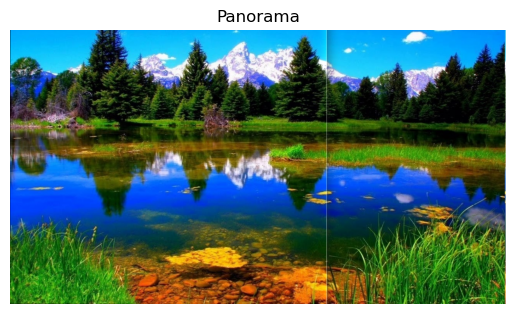

In [8]:
image_paths = [
    ROOT_DIR + 'B_original_image_right.jpg',
    ROOT_DIR + 'B_original_image_left.jpg'
    #ROOT_DIR + 'B_original_image_right.jpg'#,
    #'./img2.jpg',
]  # Edit paths; can use 2 or more images

model = 'homography'   # 'euclidean' | 'affine' | 'homography'
levels = 5             # pyramid levels for multi-band blending
ratio = 0.75           # ratio test for matching
ransac_thresh = 3.0    # symmetric transfer error threshold (px)

images = []
for p in image_paths:
    im = cv2.imread(p, cv2.IMREAD_COLOR)
    if im is None:
        raise FileNotFoundError(f'Cannot open: {p}')
    images.append(im)

panorama = stitch_images(images, model=model, ratio=ratio, ransac_thresh=ransac_thresh, levels=levels)
cv2.imwrite(str(OUT_DIR/'panorama.png'), panorama)
plt.figure(); plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)); plt.title('Panorama'); plt.axis('off'); plt.show()


### Notes & Tips
- Euclidean is most restrictive (no scale, projective effects ignored) but robust for small rotations/translation.
- Affine handles scale+shear; Homography handles general perspective.
- If inlier count is low, try lowering `CONTRAST_TH`/`HARRIS_REL_TH`, increase overlap, or try a different model.
- Increase `levels` for smoother seams (slower), or reduce for speed.
